# Simulacion de distribuciones por radio censal

**A continuación se detalla:**

1. Estimación del total de viviendas/hogares cuando la información del precenso 2020 es desconocida
2. Estimación del total de viviendas/hogares por categorías a partir del total estimado en `1`.

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os

os.environ["CENSAR_CARTO_DIR"] = "/resources/bucket/censar_carto/"
os.environ["CENSAR_DATA_DIR"] = "/resources/bucket/censar_data/"

In [3]:
# import warnings

# warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt

In [5]:
from CENSAr.datasources import (
    personas_radios_prov,
    tipoviv_radios_prov,
    radios_prov,
    radios_eph_censo_2010,
    persproy_depto_2025,
)

2023-05-22 22:35:54.147 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-22 22:35:54.148 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-22 22:35:54.149 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-22 22:35:54.150 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-22 22:35:54.150 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-22 22:35:54.151 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [6]:
from CENSAr.modeling_tools import simulate_total_var, simulate_cat_var

In [7]:
# GEOMETRIAS
envolvente = radios_eph_censo_2010(aglo_idx="08")
chaco_2001 = radios_prov(year=2001, prov="chaco", mask=envolvente)
chaco_2010 = radios_prov(year=2010, prov="chaco", mask=envolvente)

[22:35:54] INFO     /resources/bucket/censar_carto//radios_eph_json.zip                          ]8;id=113690;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=342480;file:///workspace/CENSAr/datasources.py#111\111]8;;\

In [8]:
# TABLAS REDATAM - HOGARES/VIVIENDAS
tipo_2001 = tipoviv_radios_prov(
    year=2001,
    prov="chaco",
    var_types={"link": "object"},
    root="/resources/bucket/censar_data/",
)
tipo_2001_geo = chaco_2001.set_index("link").join(tipo_2001.set_index("link"))
tipo_2010 = tipoviv_radios_prov(
    year=2010,
    prov="chaco",
    var_types={"link": "object"},
    root="/resources/bucket/censar_data/",
)
tipo_2010_geo = chaco_2010.set_index("link").join(tipo_2010.set_index("link"))

[22:36:01] INFO     loading `/resources/bucket/censar_data/tipo_vivienda_radios_chaco_2001.csv`  ]8;id=583695;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=502641;file:///workspace/CENSAr/datasources.py#121\121]8;;\

           INFO     loading `/resources/bucket/censar_data/tipo_vivienda_radios_chaco_2010.csv`  ]8;id=602095;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=615904;file:///workspace/CENSAr/datasources.py#121\121]8;;\

In [9]:
# TABLAS REDATAM - PERSONAS
pers_2001 = personas_radios_prov(year=2001, prov="chaco", var_types={"link": "object"})
pers_2001_geo = chaco_2001.set_index("link").join(pers_2001.set_index("link"))
pers_2010 = personas_radios_prov(year=2010, prov="chaco", var_types={"link": "object"})
pers_2010_geo = chaco_2010.set_index("link").join(pers_2010.set_index("link"))

           INFO     loading `/resources/bucket/censar_data/personas_radios_chaco_2001.csv`       ]8;id=705729;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=35478;file:///workspace/CENSAr/datasources.py#143\143]8;;\

           INFO     loading `/resources/bucket/censar_data/personas_radios_chaco_2010.csv`       ]8;id=570934;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=446030;file:///workspace/CENSAr/datasources.py#143\143]8;;\

In [10]:
# Tabla de proyecciones de poblacion por departamento
proy = persproy_depto_2025(prov="chaco")

           INFO     loading, `/resources/bucket/censar_data/persproyect_depto_chaco.csv`         ]8;id=929349;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=780853;file:///workspace/CENSAr/datasources.py#182\182]8;;\

In [11]:
# Total viviendas 2020
tipo_2010_geo["total_2020"] = simulate_total_var(
    gdf_pers_01=pers_2001_geo,
    gdf_var_01=tipo_2001_geo,
    gdf_pers_10=pers_2010_geo,
    gdf_var_10=tipo_2010_geo,
    proy_df=proy,
    namedept="San Fernando",
    base_year="2010",
    forecast_year="2020",
    catname="total",
)

The total number of projected households/residential units is 132131


In [12]:
from CENSAr.plots import compare_chropleths

# Total Viviendas

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


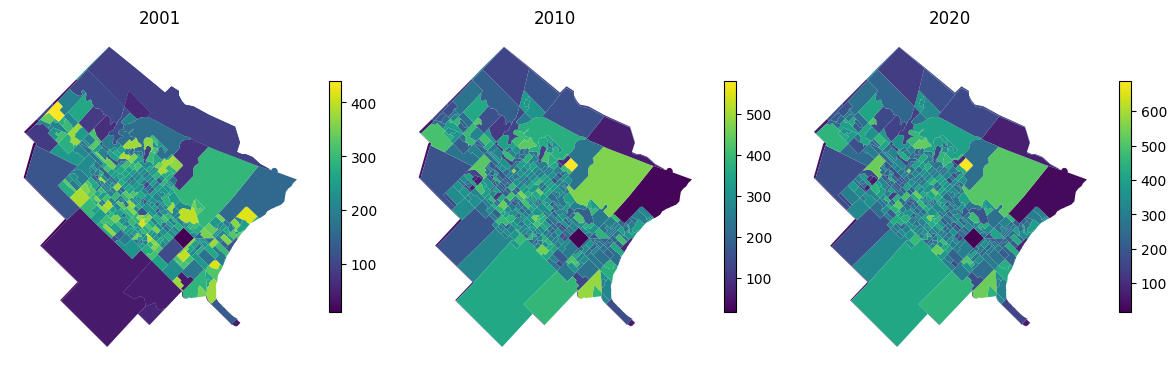

In [13]:
# CHEQUEO TOTALES VIVIENDA
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tipo_2010_geo,
    column=["total", "total", "total_2020"],
    titles=[2001, 2010, 2020],
)

# Proyeccion 2020

In [14]:
# Con catname uso la distribucion de una variable en 2001 y de otra en 2010 en funcion del diccionario que pasamos como parametro
simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_2001_geo,
    gdf_var_10=tipo_2010_geo,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_2010_geo,
    pct_val=2.5,
    catname={"2001": "casilla", "2010": "rancho"},
    tot_colname="total_2020",
)

tipo_2010_geo["informal_2020"] = tipo_2010_geo.index.map(simulated_distribution)

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


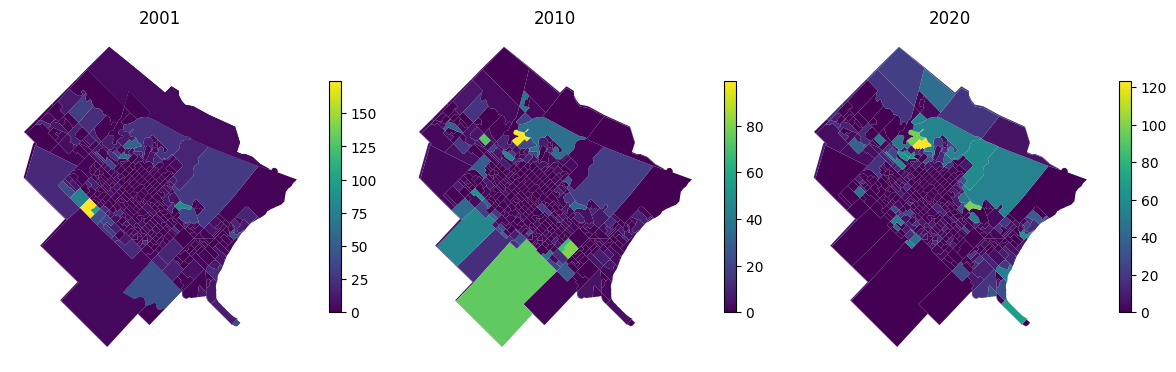

In [15]:
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tipo_2010_geo,
    column=["casilla", "casilla", "informal_2020"],
    titles=[2001, 2010, 2020],
)

In [16]:
from CENSAr.datasources import servurban_radios_prov

In [17]:
servurban_2001 = servurban_radios_prov(prov="chaco", var_types={"link": "object"})
servurban_2001_geo = tipo_2001_geo.join(servurban_2001.set_index("link"))

In [20]:
simulated_distribution = simulate_cat_var(
    gdf_var_01=servurban_2001_geo,
    gdf_var_10=tipo_2010_geo,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_2010_geo,
    pct_val=2.5,
    catname={"2001": "pavimento_no", "2010": "casilla"},
    # catname={"2001": "informal", "2010": "informal"},  # resultado de agreupacion.
    tot_colname="total_2020",
)

tipo_2010_geo["informal_2020"] = tipo_2010_geo.index.map(simulated_distribution)

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


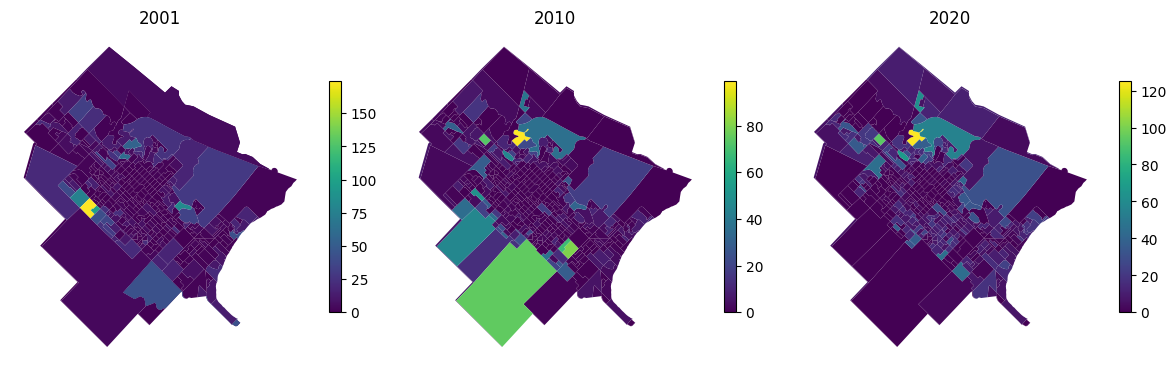

In [21]:
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tipo_2010_geo,
    column=["casilla", "casilla", "informal_2020"],
    titles=[2001, 2010, 2020],
)

# Agregacion de indicadores

In [22]:
tipo_2001_geo.columns

Index(['geometry', 'casa a', 'casa b', 'rancho', 'casilla', 'departamento',
       'pieza en inquilinato', 'pieza en hotel o pension',
       'local no construido para habitacion', 'vivienda movil', 'en la calle',
       'total'],
      dtype='object')

In [23]:
tipo_2010_geo.columns

Index(['geometry', 'casa', 'rancho', 'casilla', 'departamento',
       'pieza en inquilinato', 'pieza en hotel o pension',
       'local no construido para habitacion', 'vivienda movil', 'en la calle',
       'total', 'total_2020', 'informal_2020'],
      dtype='object')

In [31]:
from copy import deepcopy
from CENSAr.aggregation import named_aggregation

tipo_vivienda_agg_2001 = named_aggregation(
    tipo_2001_geo, name="tipo vivienda particular"
)
tipo_vivienda_agg_2010 = named_aggregation(
    tipo_2010_geo, name="tipo vivienda particular"
)

[22:53:19] INFO     Applying named aggregation `tipo vivienda particular`                                ]8;id=301045;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=892806;file:///workspace/CENSAr/aggregation/core.py#67\67]8;;\

           WARNING  Extra columns found for mapping formal: {'casa'}. Extra columns will be ignored.    ]8;id=998165;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=858684;file:///workspace/CENSAr/aggregation/core.py#123\123]8;;\

           WARNING  Extra columns found for mapping situacion de calle: {'persona viviendo en la        ]8;id=441719;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=80227;file:///workspace/CENSAr/aggregation/core.py#123\123]8;;\
                    calle'}. Extra columns will be ignored.                                                        

           INFO     Applying named aggregation `tipo vivienda particular`                                ]8;id=357930;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=382210;file:///workspace/CENSAr/aggregation/core.py#67\67]8;;\

           WARNING  Extra columns found for mapping formal: {'casa b', 'casa a'}. Extra columns will be ]8;id=193561;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=377364;file:///workspace/CENSAr/aggregation/core.py#123\123]8;;\
                    ignored.                                                                                       

           WARNING  Extra columns found for mapping situacion de calle: {'persona viviendo en la        ]8;id=854992;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=725845;file:///workspace/CENSAr/aggregation/core.py#123\123]8;;\
                    calle'}. Extra columns will be ignored.                                                        

In [34]:
formal_simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_agg_2001,
    gdf_var_10=tipo_vivienda_agg_2010,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_agg_2010,
    pct_val=2.5,
    catname={"2001": "formal", "2010": "formal"},
    tot_colname="total_2020",
)
informal_simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_agg_2001,
    gdf_var_10=tipo_vivienda_agg_2010,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_agg_2010,
    pct_val=2.5,
    catname={"2001": "informal", "2010": "informal"},
    tot_colname="total_2020",
)
calle_simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_agg_2001,
    gdf_var_10=tipo_vivienda_agg_2010,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_agg_2010,
    pct_val=2.5,
    catname={"2001": "situacion de calle", "2010": "situacion de calle"},
    tot_colname="total_2020",
)

tipo_vivienda_agg_2020 = deepcopy(tipo_vivienda_agg_2010)
tipo_vivienda_agg_2010["formal"] = tipo_vivienda_agg_2010.index.map(
    formal_simulated_distribution
)
tipo_vivienda_agg_2010["informal"] = tipo_vivienda_agg_2010.index.map(
    informal_simulated_distribution
)
tipo_vivienda_agg_2010["situacion de calle"] = tipo_vivienda_agg_2010.index.map(
    calle_simulated_distribution
)

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


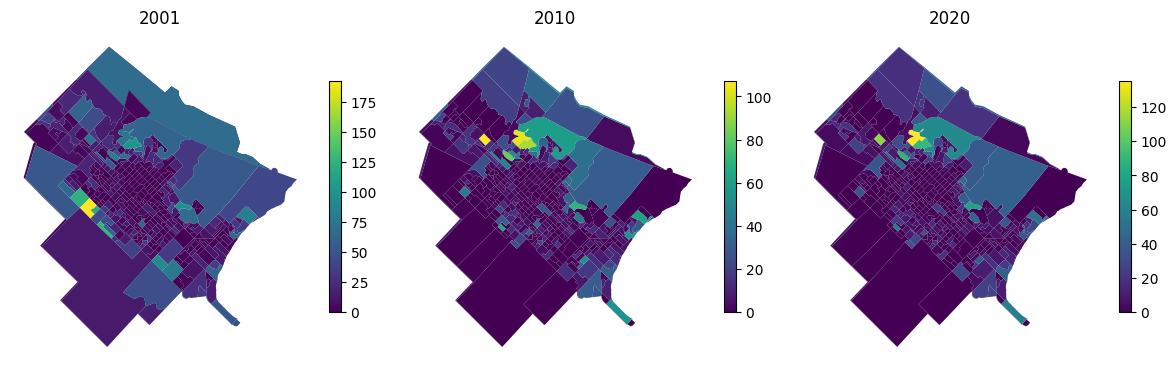

In [44]:
compare_chropleths(
    tipo_vivienda_agg_2001,
    tipo_vivienda_agg_2010,
    tipo_vivienda_agg_2020,
    column="informal",
    titles=[2001, 2010, 2020],
)

In [43]:
vulnerabilidad_2001 = named_aggregation(
    tipo_vivienda_agg_2001,
    name="vulnerabilidad urbana",
)
vulnerabilidad_2010 = named_aggregation(
    tipo_vivienda_agg_2010,
    name="vulnerabilidad urbana",
)
vulnerabilidad_2020 = named_aggregation(
    tipo_vivienda_agg_2020,
    name="vulnerabilidad urbana",
)

[23:02:51] INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=283966;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=92531;file:///workspace/CENSAr/aggregation/core.py#67\67]8;;\

           INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=781600;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=686242;file:///workspace/CENSAr/aggregation/core.py#67\67]8;;\

           INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=334191;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=135712;file:///workspace/CENSAr/aggregation/core.py#67\67]8;;\

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


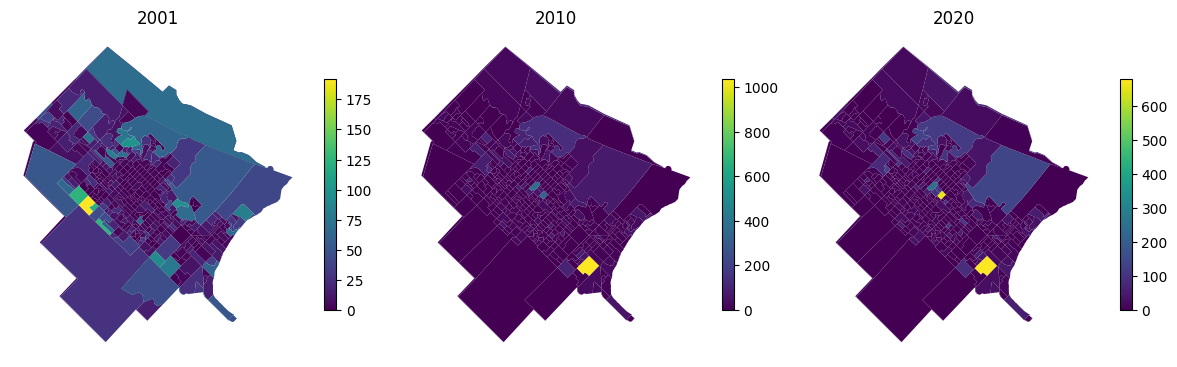

In [40]:
compare_chropleths(
    vulnerabilidad_2001,
    vulnerabilidad_2010,
    vulnerabilidad_2020,
    column="vulnerable",
    titles=[2001, 2010, 2020],
)